# 4x5 Optimization model

In [8]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate
from scipy.optimize import minimize

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from Systems_Design_Preferendus.genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

Set Weights for Different Objectives

1. City counsil         --> Costs
2. Surfing community:   --> Ride length
3. Reseach: sediment    --> Trapping
4. Local community:     --> Safety
5. Tourisme:            --> Economic growth

In [9]:
# Set weights for the objectives
w1 = 0.2  # weight for costs
w2 = 0.2  # weight for ride length
w3 = 0.2  # weight for sediment trapping
w4 = 0.2  # weight for safety
w5 = 0.2  # economic growth

assert w1 + w2 + w3 + w4 + w5 == 1

In [10]:
# Vectorized objective functions
def objective_function_1(X: np.ndarray):
    """
    Cost function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    
    """
    vars_arr = np.atleast_2d(X)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]

    cons1 = 2.5   # costs per material
    cons2 = 30  # material used per metre lenght
    cons3 = 10  # material used per metre depth 
    return cons1 * cons2 * cons3 * np.array(x1) * (10 - np.array(x2))

def objective_function_2(X: np.ndarray):
    """
    Ride-length function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    :param x3: reef peel angle
    """
    vars_arr = np.atleast_2d(X)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]

    cons4 = 0.75  # ride length gained per metre length
    cons5 = 0.6  # ride length gained per metre depth
    cons6 = 2 # optimal reef depth for ride length
    cons16 = 0.001 # sensitivity variable of ride length to peel angle   
    cons17 = 60 # optimal peel angle
    return (cons4 * np.array(x1)) / ((cons5 * (np.array(x2) - cons6)**2) + (cons16 * (np.array(x3) - cons17)) + 1)

def objective_function_3(X: np.ndarray):
    """
    Sediment-trapping function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    :param x3: reef peel angle
    :param x4: distance from shore
    """
    vars_arr = np.atleast_2d(X)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]
    
    cons7 = 130000  # sediment trapping per metre length
    cons8 = 1.5  # optimal depth for sediment trapping
    cons9 = 1.3  # sensitivity of sediment trapping to depth changes
    return cons7 * (x1 - 30) / (450 - 30) * np.exp(-1 * ((np.array(x2) - cons8) / cons9) ** 2) * (-0.0128333 * np.array(x3) +1.385) * (1 - ((np.array(x4) - 280) / 500) ** 2)

def objective_function_4(X: np.ndarray):
    """"
    Safety function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    :param x3: reef peel angle
    :param x4: distance from shore
    """
    vars_arr = np.atleast_2d(X)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]


    cons10 = 2.25 # sensitivity variable for safety and depth
    cons11 = 0.5 # minimum depth value 
    cons12 = 15 # maximum amount of injuries per year
    cons13 = 30 # minimum distance from end of reef to the shore
    cons14 = 50 # sensitivity variable for safety and distance from end of reef to the shore
    cons15 = 2 # minimum amount of injuries per year

    return ((- cons10 * (np.array(x2) - cons11)**2 + cons12) *  (cons12 * np.exp( -1 * (((np.array(x4) - np.array(x1) * np.cos((np.pi/2) - ((np.pi*np.array(x3))/180))) - cons13) / cons14)**2) + cons15) / cons12)
    
def objective_function_5(X: np.ndarray):
    """"
    Economic growth function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    """
    vars_arr = np.atleast_2d(X)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]
    
    cons16 = 70000000
    cons17 = 280
    return cons16 * (((np.array(x2) + 0.5) / 2.5) ** 3 + 1) * (np.array(x1) / cons17) * (-0.0006667 * np.array(x4) + 1)

pref1 = [[150000, 1500000, 3000000], [100, 80, 0]]
pref2 = [[30, 100, 330], [0, 50, 100]]
pref3 = [[0, 80000, 134000], [0, 100, 10]]
pref4 = [[0, 17], [100, 0]]
pref5 = [[0, 400000000], [0, 100]]

# Preference functions that convert raw objective values to 0-100 preference scores
def objective_p1(X):
    """Map cost -> preference score. Lower cost -> higher preference."""
    cost = objective_function_1(X)
    return pchip_interpolate(pref1[0], pref1[1], cost)

def objective_p2(X):
    """Map ride-length -> preference score. Higher ride length -> higher preference."""
    ride = objective_function_2(X)
    return pchip_interpolate(pref2[0], pref2[1], ride)

def objective_p3(X):
    """Map sediment trapping -> preference score. Higher sediment trapping -> higher preference."""
    sediment = objective_function_3(X)
    return pchip_interpolate(pref3[0], pref3[1], sediment)

def objective_p4(X):
    """Map safety -> preference score. Lower accidents -> higher preference."""
    safety = objective_function_4(X)
    return pchip_interpolate(pref4[0], pref4[1], safety)

def objective_p5(X):
    """Map economic growth -> preference score. Higher growth -> higher preference."""
    growth = objective_function_5(X)
    return pchip_interpolate(pref5[0], pref5[1], growth)

def objective(variables):
    """Objective function that is fed to the GA. Expects variables with two columns (x1,x2)."""
    # ensure variables is a 2D numpy array
    vars_arr = np.atleast_2d(variables)

    # calculate the preference scores (vectorized)
    p_1 = objective_p1(vars_arr)
    p_2 = objective_p2(vars_arr)
    p_3 = objective_p3(vars_arr)
    p_4 = objective_p4(vars_arr)
    p_5 = objective_p5(vars_arr)

    # return weights and preference arrays to the GA
    return [w1, w2, w3, w4, w5], [p_1, p_2, p_3, p_4, p_5]


Define Constraints and Bounds


In [11]:
def _make_bounds_constraints(objective_func, pref_knots):
    """Return lower and upper 'ineq' constraint functions for an objective.

    The GA expects inequality constraints where values <= 0 are feasible. We
    therefore return two functions:

      lower(vars) = -raw_value + x_min  (<=0 when raw_value >= x_min)
      upper(vars) =  raw_value - x_max  (<=0 when raw_value <= x_max)

    Both accept either a single individual (1D) or a population (2D) and return
    a 1D numpy array with one entry per individual.
    """
    x_nodes = np.asarray(pref_knots[0], dtype=float)
    x_min = float(np.min(x_nodes))
    x_max = float(np.max(x_nodes))

    def lower(variables):
        vars_arr = np.atleast_2d(variables)
        raw = objective_func(vars_arr)
        raw = np.asarray(raw)
        return -raw + x_min

    def upper(variables):
        vars_arr = np.atleast_2d(variables)
        raw = objective_func(vars_arr)
        raw = np.asarray(raw)
        return raw - x_max

    return lower, upper


# Build constraints automatically from the objective functions and their pref knot lists
constraint_funcs = []
objs_and_prefs = [
    (objective_function_1, pref1),
    (objective_function_2, pref2),
    (objective_function_3, pref3),
    (objective_function_4, pref4),
    (objective_function_5, pref5),
]

for obj_func, pref_knots in objs_and_prefs:
    lo, hi = _make_bounds_constraints(obj_func, pref_knots)
    constraint_funcs.append(['ineq', lo])
    constraint_funcs.append(['ineq', hi])

# Manually add any additional constraints here
def constraint_1(variables):
    """_Constraint placeholder: return per-individual zeros (no violation).

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: 1-D array (length n) with constraint values; arr>0 means violation for 'ineq' constraints.
    """
    vars_arr = np.atleast_2d(variables)
    x2 = vars_arr[:, 1]
    x3 = vars_arr[:, 2]
    x4 = vars_arr[:, 3]
    return np.array(x2) * np.cos((np.pi/2) - ((np.pi*np.array(x3))/180)) > np.array(x4)
constraint_funcs.append(['ineq', constraint_1])

# assign to cons used by the GA
cons = constraint_funcs

# set bounds for all design variables (unchanged)
b1 = [30, 450]  # x1
b2 = [0.5, 3]  # x2
b3 = [30, 90]  # x3
b4 = [30, 750]  #  x4
bounds = [b1, b2, b3, b4]


Find minimum and maximim objective values

In [12]:
objectives = [
    (objective_function_1, "Cost", "$"),
    (objective_function_2, "Ride Length", "m"),
    (objective_function_3, "Sediment Trapping", "m^3/year"),
    (objective_function_4, "Safety", "accidents"),
    (objective_function_5, "Economic Growth", "$")
]

objective_minmax = {}

for idx, (obj_func, name, unit) in enumerate(objectives):
    
    # For minimization
    result_min = minimize(
        lambda x: obj_func(np.array([x]))[0],
        x0=[240, 1.75, 60, 390],  # midpoint of bounds as starting point
        bounds=bounds,
        method='L-BFGS-B'
    )
    min_val = result_min.fun
    
    # For maximization (minimize negative)
    result_max = minimize(
        lambda x: -obj_func(np.array([x]))[0],
        x0=[240, 1.75, 60, 390],
        bounds=bounds,
        method='L-BFGS-B'
    )
    max_val = -result_max.fun
    
    objective_minmax[name] = min_val, max_val

    print(f"Objective {idx+1}: min = {min_val:.4f}, max = {max_val:.4f}")

print("\nObjective Min/Max Dictionary:")
print(objective_minmax)


Objective 1: min = 157500.0000, max = 3206250.0000
Objective 2: min = 9.4538, max = 347.9381
Objective 3: min = 0.0000, max = 130000.1300
Objective 4: min = 0.1250, max = 17.0000
Objective 5: min = 3989800.5000, max = 412775578.8000

Objective Min/Max Dictionary:
{'Cost': (np.float64(157500.0), np.float64(3206250.0)), 'Ride Length': (np.float64(9.453781512605042), np.float64(347.93814432989694)), 'Sediment Trapping': (np.float64(0.0), np.float64(130000.12999992233)), 'Safety': (np.float64(0.12502482829556044), np.float64(16.999999999999872)), 'Economic Growth': (np.float64(3989800.4999999995), np.float64(412775578.7999999))}


## Preference functions


Saved preference functions figure to: c:\Users\31633\Documents\TU Delft\Master\Interdiscilinary Mechanics and Design\U1\narrowneck-reef-2025\output\preference-functions\4x5_preference_functions_after_game.png


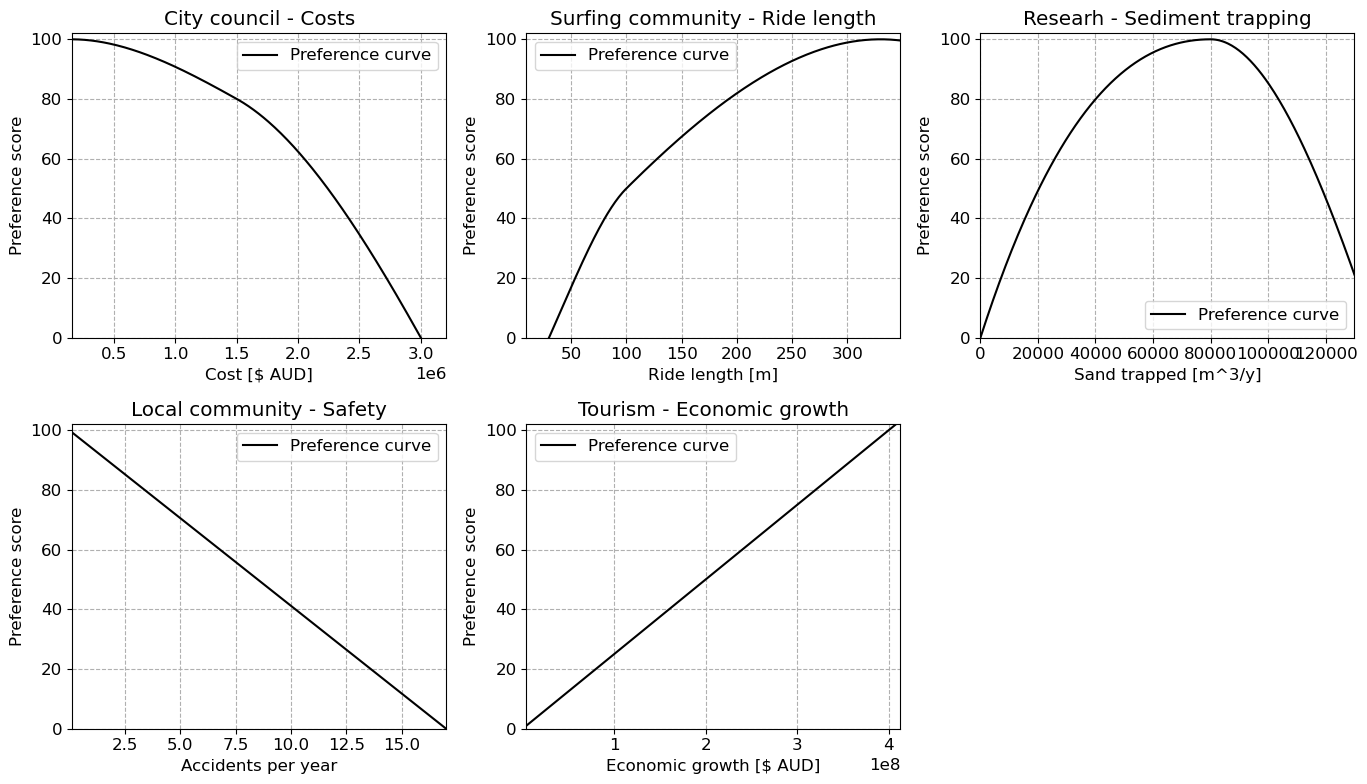

In [13]:
c1_vals = np.linspace(objective_minmax['Cost'][0], objective_minmax['Cost'][1], 300)
c2_vals = np.linspace(objective_minmax['Ride Length'][0], objective_minmax['Ride Length'][1], 300)
c3_vals = np.linspace(objective_minmax['Sediment Trapping'][0], objective_minmax['Sediment Trapping'][1], 300)
c4_vals = np.linspace(objective_minmax['Safety'][0], objective_minmax['Safety'][1], 300)
c5_vals = np.linspace(objective_minmax['Economic Growth'][0], objective_minmax['Economic Growth'][1], 300)

# calculate the preference functions using the same knots as the preference mappings
p1_vals = pchip_interpolate(pref1[0], pref1[1], c1_vals)
p2_vals = pchip_interpolate(pref2[0], pref2[1], c2_vals)
p3_vals = pchip_interpolate(pref3[0], pref3[1], c3_vals)
p4_vals = pchip_interpolate(pref4[0], pref4[1], c4_vals)
p5_vals = pchip_interpolate(pref5[0], pref5[1], c5_vals)

# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((14,8)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(c1_vals, p1_vals, label='Preference curve', color='black')
ax1.set_xlim((min(c1_vals), max(c1_vals)))
ax1.set_ylim((0, 102))
ax1.set_title('City council - Costs')
ax1.set_xlabel('Cost [$ AUD]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.grid(linestyle = '--')

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(c2_vals, p2_vals, label='Preference curve', color='black')
ax2.set_xlim((min(c2_vals), max(c2_vals)))
ax2.set_ylim((0, 102))
ax2.set_title('Surfing community - Ride length')
ax2.set_xlabel('Ride length [m]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

# Add third subplot for sediment trapping preference curve
ax3 = fig.add_subplot(2, 3, 3) 
ax3.plot(c3_vals, p3_vals, label='Preference curve', color='black')
ax3.set_xlim((min(c3_vals), max(c3_vals)))
ax3.set_ylim((0, 102))
ax3.set_title('Researh - Sediment trapping')
ax3.set_xlabel('Sand trapped [m^3/y]')
ax3.set_ylabel('Preference score')
ax3.grid()
ax3.legend()
ax3.grid(linestyle = '--')

ax4 = fig.add_subplot(2, 3, 4) 
ax4.plot(c4_vals, p4_vals, label='Preference curve', color='black')
ax4.set_xlim((min(c4_vals), max(c4_vals)))
ax4.set_ylim((0, 102))
ax4.set_title('Local community - Safety')
ax4.set_xlabel('Accidents per year')
ax4.set_ylabel('Preference score')
ax4.grid()
ax4.legend()
ax4.grid(linestyle = '--')

ax5 = fig.add_subplot(2, 3, 5) 
ax5.plot(c5_vals, p5_vals, label='Preference curve', color='black')
ax5.set_xlim((min(c5_vals), max(c5_vals)))
ax5.set_ylim((0, 102))
ax5.set_title('Tourism - Economic growth')
ax5.set_xlabel('Economic growth [$ AUD]')
ax5.set_ylabel('Preference score')
ax5.grid()
ax5.legend()
ax5.grid(linestyle = '--')


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
fig.tight_layout()

#Two lines to make our compiler able to draw:
# ensure output directory exists and save the figure
out_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output', 'preference-functions') if 'Systems_Design_Preferendus' in os.getcwd() else os.path.join(os.getcwd(), '..', 'output', 'preference-functions')
out_dir = os.path.abspath(out_dir)
fn = os.path.join(out_dir, '4x5_preference_functions_after_game.png')
fig.savefig(fn, dpi=300, bbox_inches='tight')
print(f'Saved preference functions figure to: {fn}')

Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader. Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.



Run GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            7.8114       7272742.2444     0            0.005        40          
1            6.7702       363646.9865      0            0.072        2           
2            6.5708       181826.649       0            0.113        1           
3            6.5239       181825.8307      0            0.124        1           
4            6.5001       181825.4784      0            0.224        1           
5            6.4692       181825.2828      0            0.228        1           
6            6.4692       181825.3088      1            0.228        1           
7            6.4692       181825.1521      2            0.232        1           
8            6.4692       181825.1542      3            0.234        1           
9            6.4692       181825.0777      4            0.236        1           
10           6.4692 

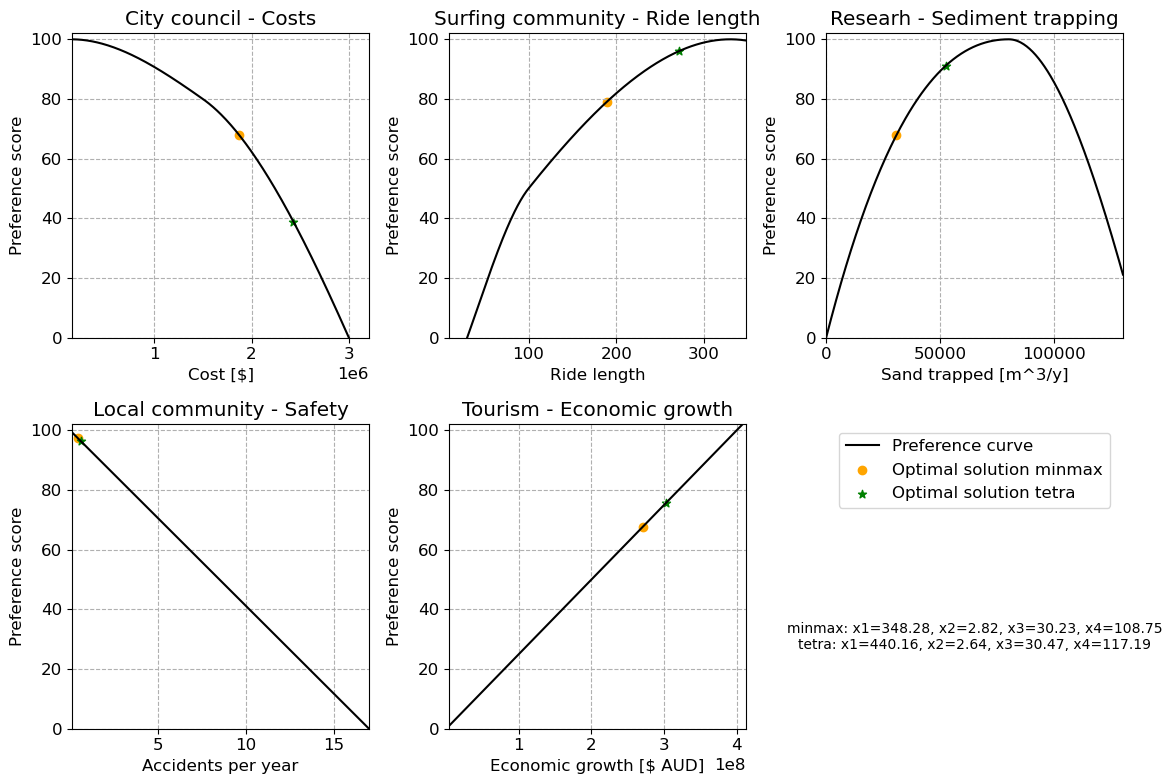

In [ ]:
# Run the optimization with two paradigms (minmax and tetra)
paradigm = ['minmax', 'tetra']
marker = ['o', '*']
colours = ['orange','green']

# Prepare figure and axes
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)

# list to collect optimal variables for each method
opt_results = []

for i, agg in enumerate(paradigm):
    # GA options
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,
        'aggregation': agg,  # minmax or tetra
        'var_type': 'real'
    }

    # run the GA and get result
    print(f'Run GA with {agg}')
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score, design_variables, _ = ga.run()

    x1_opt = float(design_variables[0])
    x2_opt = float(design_variables[1])
    x3_opt = float(design_variables[2])
    x4_opt = float(design_variables[3])

    # store optimal variables for later display
    opt_results.append((agg, x1_opt, x2_opt, x3_opt, x4_opt))

    print(f'Optimal result for x1 = {round(x1_opt, 2)}, x2 = {round(x2_opt, 2)}, x3 = {round(x3_opt, 2)}, x4 = {round(x4_opt, 2)}')

    # compute raw objective values and preference scores for the optimal design
    c1_res = float(np.atleast_1d(objective_function_1(design_variables))[0])
    p1_res = float(np.atleast_1d(objective_p1(design_variables))[0])

    c2_res = float(np.atleast_1d(objective_function_2(design_variables))[0])
    p2_res = float(np.atleast_1d(objective_p2(design_variables))[0])

    c3_res = float(np.atleast_1d(objective_function_3(design_variables))[0])
    p3_res = float(np.atleast_1d(objective_p3(design_variables))[0])

    c4_res = float(np.atleast_1d(objective_function_4(design_variables))[0])
    p4_res = float(np.atleast_1d(objective_p4(design_variables))[0])

    c5_res = float(np.atleast_1d(objective_function_5(design_variables))[0])
    p5_res = float(np.atleast_1d(objective_p5(design_variables))[0])

    # Debug prints
    print(f"c1_res: {c1_res:.2f}, p1_res: {p1_res:.1f}")
    print(f"c2_res: {c2_res:.2f}, p2_res: {p2_res:.1f}")
    print(f"c3_res: {c3_res:.2f}, p3_res: {p3_res:.1f}")
    print(f"c4_res: {c4_res:.2f}, p4_res: {p4_res:.1f}")
    print(f"c5_res: {c5_res:.2f}, p5_res: {p5_res:.1f}")

    # Plot preference curves once (they are defined over the raw objective axes)
    if i == 0:
        # cost preference curve (use the same knots as objective_p1)
        ax1.plot(c1_vals, p1_vals, label='Preference curve', color='black')
        ax1.set_xlim((min(c1_vals), max(c1_vals)))
        ax1.set_ylim((0, 102))
        ax1.set_title('City council - Costs')
        ax1.set_xlabel('Cost [$]')
        ax1.set_ylabel('Preference score')
        ax1.grid(linestyle='--')

        # ride-length preference curve (use the same knots as objective_p2)
        ax2.plot(c2_vals, p2_vals, label='Preference curve', color='black')
        ax2.set_xlim((min(c2_vals), max(c2_vals)))
        ax2.set_ylim((0, 102))
        ax2.set_title('Surfing community - Ride length')
        ax2.set_xlabel('Ride length')
        ax2.set_ylabel('Preference score')
        ax2.grid(linestyle='--')
        
        ax3.plot(c3_vals, p3_vals, label='Preference curve', color='black')
        ax3.set_xlim((min(c3_vals), max(c3_vals)))
        ax3.set_ylim((0, 102))
        ax3.set_title('Research - Sediment trapping')
        ax3.set_xlabel('Sand trapped [m^3/y]')
        ax3.set_ylabel('Preference score')
        ax3.grid(linestyle='--')
        
        ax4.plot(c4_vals, p4_vals, label='Preference curve', color='black')
        ax4.set_xlim((min(c4_vals), max(c4_vals)))
        ax4.set_ylim((0, 102))
        ax4.set_title('Local community - Safety')
        ax4.set_xlabel('Accidents per year')
        ax4.set_ylabel('Preference score')
        ax4.grid(linestyle='--')
        
        ax5.plot(c5_vals, p5_vals, label='Preference curve', color='black')
        ax5.set_xlim((min(c5_vals), max(c5_vals)))
        ax5.set_ylim((0, 102))
        ax5.set_title('Tourism - Economic growth')
        ax5.set_xlabel('Economic growth [$ AUD]')
        ax5.set_ylabel('Preference score')
        ax5.grid(linestyle='--')
        
        
    # Scatter the GA result on the preference plots
    ax1.scatter(c1_res, p1_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])
    ax2.scatter(c2_res, p2_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])
    ax3.scatter(c3_res, p3_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])
    ax4.scatter(c4_res, p4_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])
    ax5.scatter(c5_res, p5_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])

# add legend
# create empty subplot in position 6 and hide axes
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
# collect unique handles/labels from the other axes (preserve order)
handles = []
labels = []
for a in (ax1, ax2, ax3, ax4, ax5):
    h, l = a.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)
# place combined legend centered in the empty subplot
ax6.legend(handles, labels, loc='upper center')

# below the legend, print optimal x1/x2 for each method
# build text lines
text_lines = []
for agg, x1v, x2v, x3v, x4v in opt_results:
    text_lines.append(f"{agg}: x1={x1v:.2f}, x2={x2v:.2f}, x3={x3v:.2f}, x4={x4v:.2f}")

# place the text below the legend
ax6.text(0.5, 0.35, "\n".join(text_lines), ha='center', va='top', fontsize=10, transform=ax6.transAxes)

fig.tight_layout()

# ensure output directory exists and save the optimization figure with timestamp
out_dir_opt = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output', 'optimization') if 'Systems_Design_Preferendus' in os.getcwd() else os.path.join(os.getcwd(), '..', 'output', 'optimization')
out_dir_opt = os.path.abspath(out_dir_opt)
os.makedirs(out_dir_opt, exist_ok=True)
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fn_opt = os.path.join(out_dir_opt, f'4x5_optimization_results_after_game_{timestamp}.png')
fig.savefig(fn_opt, dpi=300, bbox_inches='tight')
print(f'Saved optimization figure to: {fn_opt}')
plt.show()